## **LIBRARIES**

In [ ]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_small/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")
tracks_path = os.path.join(metadata_path, "tracks.csv")
genres_path = os.path.join(metadata_path, "genres.csv")
features_path = os.path.join(metadata_path, "features.csv")

target_sr = 22050
fmax = 8000

SEED = 42
np.random.seed(SEED)

## **DATASET INSPECT**

In [ ]:
# MultiIndex'li sütunları düzleştir
features_df = pd.read_csv(features_path, header=[0, 1, 2], index_col=0)
features_df.columns = ['_'.join(col).strip() for col in features_df.columns.values]

# Temizlik
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.dropna(inplace=True)
print("✅ Tüm özellikler yüklendi:", features_df.shape)


✅ Tüm özellikler yüklendi: (106574, 518)


In [ ]:
print(features_df.columns[:10])

Index(['chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02',
       'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04',
       'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06',
       'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08',
       'chroma_cens_kurtosis_09', 'chroma_cens_kurtosis_10'],
      dtype='object')


In [ ]:
# fma_small track ID'leri
track_ids = []
for root, _, files in os.walk(audio_path):
    for file in files:
        if file.endswith(".mp3"):
            track_id = int(file.replace(".mp3", ""))
            track_ids.append(track_id)
track_ids = sorted(track_ids)

# tracks.csv → genre_top eşleşmesi
tracks_df = pd.read_csv(tracks_path, index_col=0, header=[0, 1])
genre_series = tracks_df["track"]["genre_top"]

# Yalnızca fma_small'a karşılık gelen satırlar
features_df_small = features_df.loc[features_df.index.intersection(track_ids)]
features_df_small["genre_top"] = genre_series
features_df_small.dropna(subset=["genre_top"], inplace=True)

print("✅ fma_small eşleşen shape:", features_df_small.shape)


✅ fma_small eşleşen shape: (8000, 519)


In [ ]:
X = features_df_small.drop(columns=["genre_top"]).values
y = features_df_small["genre_top"].astype("category").cat.codes.values
genre_labels = features_df_small["genre_top"].astype("category").cat.categories


## **TRAIN / TEST SET SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=150)
X_new = selector.fit_transform(X, y)

# train/test split tekrar
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, stratify=y, random_state=SEED
)

## **TRAIN MODEL**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

param_grid = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)

y_pred = grid.predict(X_test_scaled)
print("🎯 SVM Sonuçları:\n")
print(classification_report(y_test, y_pred, target_names=genre_labels))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
🔍 En iyi parametreler: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🎯 SVM Sonuçları:

               precision    recall  f1-score   support

   Electronic       0.60      0.65      0.62       200
 Experimental       0.51      0.64      0.57       200
         Folk       0.66      0.74      0.70       200
      Hip-Hop       0.67      0.62      0.64       200
 Instrumental       0.62      0.61      0.62       200
International       0.76      0.71      0.74       200
          Pop       0.42      0.36      0.39       200
         Rock       0.69      0.57      0.62       200

     accuracy                           0.61      1600
    macro avg       0.62      0.61      0.61      1600
 weighted avg       0.62      0.61      0.61      1600



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🌲 Random Forest:\n")
print(classification_report(y_test, y_pred_rf, target_names=genre_labels))

🌲 Random Forest:

               precision    recall  f1-score   support

   Electronic       0.59      0.56      0.57       200
 Experimental       0.57      0.41      0.48       200
         Folk       0.64      0.76      0.69       200
      Hip-Hop       0.55      0.65      0.59       200
 Instrumental       0.58      0.61      0.60       200
International       0.61      0.60      0.61       200
          Pop       0.36      0.32      0.34       200
         Rock       0.59      0.62      0.61       200

     accuracy                           0.57      1600
    macro avg       0.56      0.57      0.56      1600
 weighted avg       0.56      0.57      0.56      1600



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_knn.fit(X_train_scaled, y_train)

print("🔍 En iyi KNN parametreler:", grid_knn.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 En iyi KNN parametreler: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [ ]:
y_pred_knn = grid_knn.predict(X_test_scaled)

print("📌 KNN GridSearch Sonuçları:\n")
print(classification_report(y_test, y_pred_knn, target_names=genre_labels))

📌 KNN GridSearch Sonuçları:

               precision    recall  f1-score   support

   Electronic       0.70      0.32      0.44       200
 Experimental       0.59      0.28      0.38       200
         Folk       0.55      0.72      0.63       200
      Hip-Hop       0.50      0.59      0.55       200
 Instrumental       0.62      0.46      0.53       200
International       0.39      0.77      0.52       200
          Pop       0.35      0.31      0.33       200
         Rock       0.57      0.57      0.57       200

     accuracy                           0.50      1600
    macro avg       0.53      0.50      0.49      1600
 weighted avg       0.53      0.50      0.49      1600



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]  # convergence problemi yaşamamak için
}

grid_logreg = GridSearchCV(
    LogisticRegression(),
    param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_logreg.fit(X_train_scaled, y_train)
print("🔍 En iyi Logistic Regression parametreler:", grid_logreg.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
🔍 En iyi Logistic Regression parametreler: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
y_pred_logreg = grid_logreg.predict(X_test_scaled)

print("📌 Logistic Regression Sonuçları:\n")
print(classification_report(y_test, y_pred_logreg, target_names=genre_labels))

📌 Logistic Regression Sonuçları:

               precision    recall  f1-score   support

   Electronic       0.58      0.57      0.58       200
 Experimental       0.54      0.48      0.51       200
         Folk       0.70      0.74      0.72       200
      Hip-Hop       0.59      0.67      0.63       200
 Instrumental       0.60      0.63      0.61       200
International       0.64      0.67      0.65       200
          Pop       0.39      0.32      0.35       200
         Rock       0.59      0.60      0.59       200

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



## **Eval**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"\n📊 {model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels))

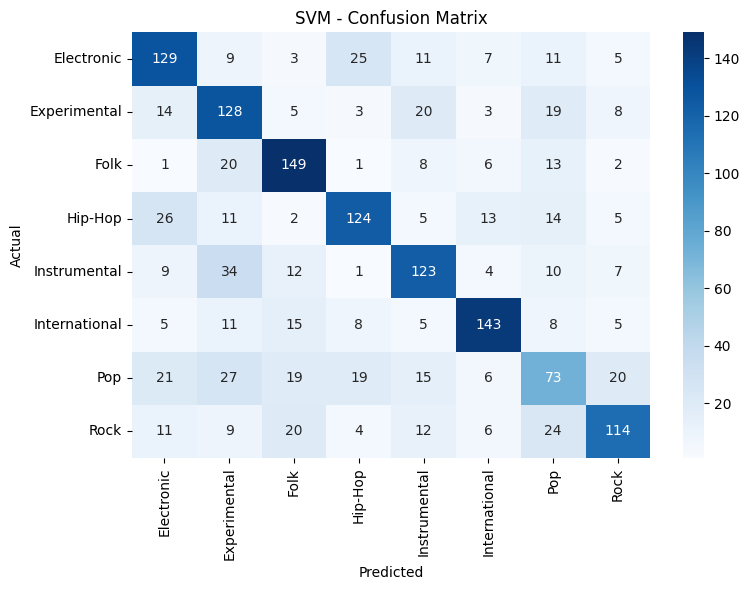


📊 SVM Classification Report:

               precision    recall  f1-score   support

   Electronic       0.60      0.65      0.62       200
 Experimental       0.51      0.64      0.57       200
         Folk       0.66      0.74      0.70       200
      Hip-Hop       0.67      0.62      0.64       200
 Instrumental       0.62      0.61      0.62       200
International       0.76      0.71      0.74       200
          Pop       0.42      0.36      0.39       200
         Rock       0.69      0.57      0.62       200

     accuracy                           0.61      1600
    macro avg       0.62      0.61      0.61      1600
 weighted avg       0.62      0.61      0.61      1600



In [ ]:
evaluate_model(y_test, y_pred, "SVM", genre_labels)

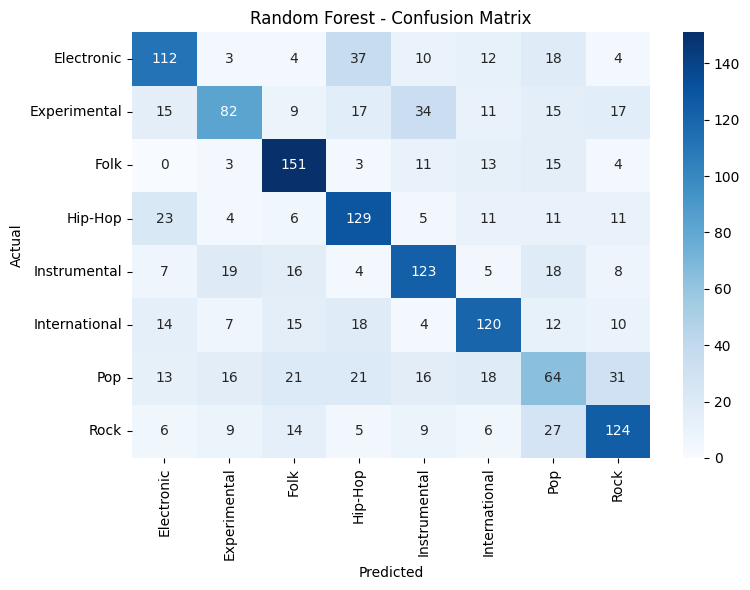


📊 Random Forest Classification Report:

               precision    recall  f1-score   support

   Electronic       0.59      0.56      0.57       200
 Experimental       0.57      0.41      0.48       200
         Folk       0.64      0.76      0.69       200
      Hip-Hop       0.55      0.65      0.59       200
 Instrumental       0.58      0.61      0.60       200
International       0.61      0.60      0.61       200
          Pop       0.36      0.32      0.34       200
         Rock       0.59      0.62      0.61       200

     accuracy                           0.57      1600
    macro avg       0.56      0.57      0.56      1600
 weighted avg       0.56      0.57      0.56      1600



In [ ]:
evaluate_model(y_test, y_pred_rf, "Random Forest", genre_labels)

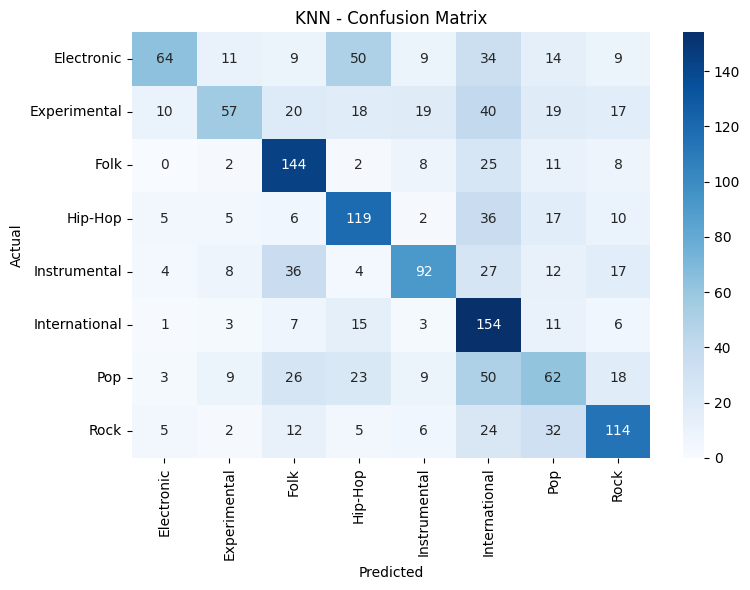


📊 KNN Classification Report:

               precision    recall  f1-score   support

   Electronic       0.70      0.32      0.44       200
 Experimental       0.59      0.28      0.38       200
         Folk       0.55      0.72      0.63       200
      Hip-Hop       0.50      0.59      0.55       200
 Instrumental       0.62      0.46      0.53       200
International       0.39      0.77      0.52       200
          Pop       0.35      0.31      0.33       200
         Rock       0.57      0.57      0.57       200

     accuracy                           0.50      1600
    macro avg       0.53      0.50      0.49      1600
 weighted avg       0.53      0.50      0.49      1600



In [ ]:
evaluate_model(y_test, y_pred_knn, "KNN", genre_labels)

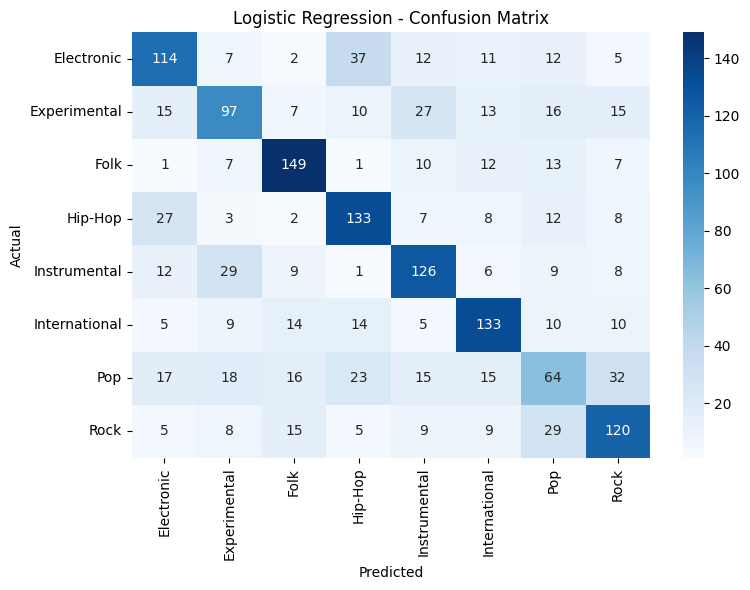


📊 Logistic Regression Classification Report:

               precision    recall  f1-score   support

   Electronic       0.58      0.57      0.58       200
 Experimental       0.54      0.48      0.51       200
         Folk       0.70      0.74      0.72       200
      Hip-Hop       0.59      0.67      0.63       200
 Instrumental       0.60      0.63      0.61       200
International       0.64      0.67      0.65       200
          Pop       0.39      0.32      0.35       200
         Rock       0.59      0.60      0.59       200

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



In [ ]:
evaluate_model(y_test, y_pred_logreg, "Logistic Regression", genre_labels)